In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()

In [3]:
# Function to get lineage of a given taxonomy ID
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon 23 Sep 11:24:38 BST 2019

@author: sejmodha
"""

def get_ancestors(taxid):
    """A function to get lineage of a given taxonomy ID"""
    lineage = []
    try:
        lineage = ncbi.get_lineage(taxid)
    except ValueError:
        lineage = None
        pass
    return lineage

def get_lca(taxon1,taxon2):
    """Function to get LCA between two taxonomy IDs"""
    if taxon1 is not None and taxon2 is not None:
        viralhits = 0
        #print(f'getting LCA of {taxon1} and {taxon2}')
        ancestors_1 = get_ancestors(taxon1)[::-1]
        ancestors_2 = get_ancestors(taxon2)[::-1]
        for ancestor in ancestors_1:
            #print(ancestor)
            if ancestor in ancestors_2:
                return ancestor
    else:
        print(taxon1, taxon2)

def get_lca_list(taxalist):
    """A function to get LCA of a given list of taxonomy IDs"""
    #print(f'Taxalist is : {taxalist}')
    taxon1 = int(taxalist.pop())
    while len(taxalist) > 0:
        taxon2 = int(taxalist.pop())
        lca = get_lca(taxon1, taxon2)
        #print(f'LCA of {taxon1} and {taxon2} is {lca}')
        taxon1 = lca
    return taxon1

In [ ]:
file_af = "./foldseek_structure_resps_vs_AFDB/foldseek_structure_reps_vs_AFDB.tsv" # Foldseek results for AFDB search (file size is over 700 MB)
df_af = pd.read_csv(file_af, sep="\t")

In [6]:
df_af = df_af[df_af['evalue'] < 1e-3]

In [7]:
df_af = df_af.sort_values(by=["query", "evalue"], ascending=True)
df_af = df_af.drop_duplicates(subset="query", keep="first")

In [ ]:
n = 0

for index, row in df_af.iterrows():

    taxid = row['taxid']

    lineage = ncbi.get_lineage(taxid)
    lineage_names = ncbi.get_taxid_translator(lineage)
    lineage_ranks = ncbi.get_rank(lineage)

    lineage_ranks_names = {lineage_ranks[i]: lineage_names[i] for i in lineage}

    try:
        superkingdom = lineage_ranks_names['superkingdom']
    except KeyError:
        superkingdom = 'None'
    
    try:
        no_rank = lineage_ranks_names['no rank']
    except KeyError:
        no_rank = 'None'

    df_af.at[index, 'no rank'] = no_rank
    df_af.at[index, 'superkingdom'] = superkingdom
    
    n += 1
    
    print(n, taxid, no_rank, superkingdom)

In [11]:
df_af.to_csv("./foldseek_structure_reps_vs_AFDB/foldseek_structure_reps_vs_AFDB_with_superkingdom.csv", index=False)

In [2]:
file_af = "./foldseek_structure_reps_vs_AFDB/foldseek_structure_reps_vs_AFDB_with_superkingdom.csv"
df_af = pd.read_csv(file_af)

In [4]:
df_af.columns

Index(['query', 'target', 'theader', 'fident', 'alnlen', 'mismatch', 'gapopen',
       'qstart', 'qend', 'qlen', 'qcov', 'tstart', 'tend', 'tlen', 'tcov',
       'evalue', 'bits', 'prob', 'lddt', 'alntmscore', 'taxname', 'taxid',
       'no rank', 'superkingdom'],
      dtype='object')

In [6]:
df_af.loc[df_af['superkingdom'].isna(), 'no rank'].value_counts()

no rank
organismal metagenomes               21200
ecological metagenomes                4721
miscellaneous sequences                167
unclassified sequences                 112
prokaryotic environmental samples       86
vectors                                 62
environmental samples                   49
metagenomes                             27
plasmids                                 3
transposons                              2
Name: count, dtype: int64

In [3]:
df_af = df_af.sort_values(by=["query", "evalue"], ascending=True)
df_af = df_af.drop_duplicates(subset="query", keep="first")

In [4]:
# for rows where superkingdom is None, put the no rank values to the superkingdom column
df_af.loc[df_af['superkingdom'].isna(), 'superkingdom'] = 'Other'

In [5]:
df_af['superkingdom'].value_counts()

superkingdom
Eukaryota    2425
Bacteria      540
Other         371
Archaea        57
Name: count, dtype: int64

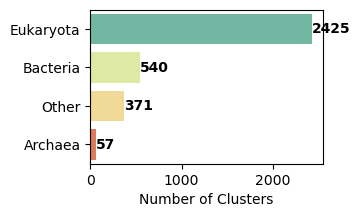

In [6]:
plt.figure(figsize=(3, 2))

ax = sns.countplot(y='superkingdom', data=df_af, hue='superkingdom', palette='Spectral_r', order=df_af['superkingdom'].value_counts().index)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.8,  
             p.get_y() + p.get_height() / 2,
             '{:1.0f}'.format(width),
             ha = 'left',
             va = 'center',
             weight='bold')

#for label in ax.get_yticklabels():
#    label.set_weight('bold')

# Make the x-tick labels bold
#for label in ax.get_xticklabels():
#    label.set_weight('bold')

plt.ylabel('')
#plt.xlabel('Number of Clusters', weight='bold')
plt.xlabel('Number of Clusters')
plt.savefig('./figures/afdb_hits/cluster_counts_per_afdb_superkingdom.svg', format='svg', bbox_inches='tight')
plt.show()

In [6]:
file = "./foldseek_structure_reps_vs_AFDB/foldseek_structure_reps_vs_AFDB_with_superkingdom.csv"
df_af_superkingdom = pd.read_csv(file)
file_stats = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(file_stats)

In [7]:
# drow rows with superkingdom NaN values
df_af_superkingdom = df_af_superkingdom.dropna(subset=['superkingdom'])

In [8]:
df_af_superkingdom = df_af_superkingdom.merge(df_stats[['structure_representative', 'cluster_id', 'cluster_size', 'ictv_lca', 'ictv_lca_rank', 'top_genbank_name', 'Pfam_annotation_type', 'Pfam_annotation']], left_on='query', right_on='structure_representative')
df_af_superkingdom.drop(columns=['structure_representative'], inplace=True)

In [9]:
df_af_superkingdom[df_af_superkingdom['cluster_id'] == 1547].iloc[:,:25]

,query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,qlen,...,evalue,bits,prob,lddt,alntmscore,taxname,taxid,no rank,superkingdom,cluster_id
629458,CF-AUG72299.1_42_relaxed,AF-A0A818I6J2-F1-model_v4,AF-A0A818I6J2-F1-model_v4 Hypothetical protein,0.099,682,407,40,268,900,1384,...,5.513000e-10,248,1.000,0.4155,0.4728,Rotaria sp. Silwood1,2762511,unclassified Rotaria,Eukaryota,1547
629459,CF-AUG72299.1_42_relaxed,AF-F2PV83-F1-model_v4,AF-F2PV83-F1-model_v4 Chitinase,0.107,709,404,35,268,891,1384,...,2.202000e-04,85,0.992,0.2891,0.2582,Trichophyton equinum CBS 127.97,559882,cellular organisms,Eukaryota,1547


In [10]:
df_af_superkingdom = df_af_superkingdom.sort_values(by=["query", "evalue"], ascending=True)
df_af_superkingdom = df_af_superkingdom.drop_duplicates(subset="query", keep="first")

In [11]:
df_af_superkingdom.shape

(3322, 31)

In [12]:
df_af_superkingdom['superkingdom'].value_counts()

superkingdom
Eukaryota    2520
Bacteria      709
Archaea        93
Name: count, dtype: int64

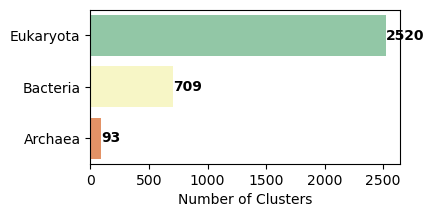

In [21]:
plt.figure(figsize=(4, 2))

ax = sns.countplot(y='superkingdom', data=df_af_superkingdom,
                   hue='superkingdom', palette='Spectral_r',
                   order=df_af_superkingdom['superkingdom'].value_counts().index,
                   legend=False)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.8,  
             p.get_y() + p.get_height() / 2,
             '{:1.0f}'.format(width),
             ha = 'left',
             va = 'center',
             weight='bold')

#for label in ax.get_yticklabels():
#    label.set_weight('bold')

# Make the x-tick labels bold
#for label in ax.get_xticklabels():
#    label.set_weight('bold')

plt.ylabel('')
#plt.xlabel('Number of Clusters', weight='bold')
plt.xlabel('Number of Clusters')
#plt.savefig('./figures/afdb_hits/cluster_counts_per_afdb_superkingdom_cellular.svg', format='svg', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3152044/1622406858.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fident', y='taxname', data=df_af_superkingdom,


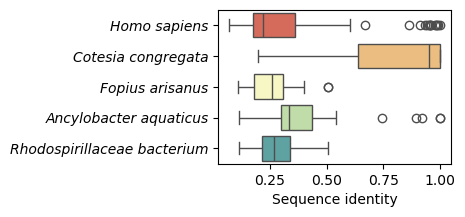

In [15]:
# for top 10 taxnames, plot the distribution of fident

# The seaborn.boxplot function in Seaborn creates a box plot,
# which is a standardized way of displaying the distribution of data
# based on a five-number summary. By default, a box plot shows the following:

# Median: The line inside the box represents the median (50th percentile) of the data.
# Interquartile Range (IQR): The box itself represents the interquartile range,
# which is the range between the 25th percentile (Q1) and the 75th percentile (Q3).
# Whiskers: The "whiskers" extend from the box to the smallest and largest values
# within 1.5 times the IQR from the lower and upper quartiles, respectively.
# Outliers: Data points outside the whiskers are considered outliers and are plotted as individual points.

plt.figure(figsize=(3, 2))

ax = sns.boxplot(x='fident', y='taxname', data=df_af_superkingdom,
                 order=df_af_superkingdom['taxname'].value_counts().index[:5],
                 palette='Spectral')

for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

plt.xlabel('Sequence identity')
plt.ylabel('')
plt.savefig('./figures/afdb_hits/identity_distribution_top5_taxnames.svg', format='svg', bbox_inches='tight')
plt.show()

In [14]:
df_af_superkingdom.columns

Index(['query', 'target', 'theader', 'fident', 'alnlen', 'mismatch', 'gapopen',
       'qstart', 'qend', 'qlen', 'qcov', 'tstart', 'tend', 'tlen', 'tcov',
       'evalue', 'bits', 'prob', 'lddt', 'alntmscore', 'taxname', 'taxid',
       'no rank', 'superkingdom', 'cluster_id', 'cluster_size', 'ictv_lca',
       'ictv_lca_rank', 'top_genbank_name', 'Pfam_annotation_type',
       'Pfam_annotation'],
      dtype='object')

In [18]:
df_af_superkingdom[df_af_superkingdom['taxname'] == 'Cotesia congregata'].sort_values(by='fident', ascending=False)

,query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,qlen,...,taxid,no rank,superkingdom,cluster_id,cluster_size,ictv_lca,ictv_lca_rank,top_genbank_name,Pfam_annotation_type,Pfam_annotation
657099,CF-CAG18436.1_12723_relaxed,AF-S6CVR4-F1-model_v4,AF-S6CVR4-F1-model_v4 Uncharacterized protein,1.000,251,0,0,1,251,251,...,51543,cellular organisms,Eukaryota,1711,8,Viruses,Superkingdom,Product: hypothetical protein; Note: ORF2,NaN,NaN
214907,CF-CAG17468.1_12723_relaxed,AF-S6D9I0-F1-model_v4,AF-S6D9I0-F1-model_v4 Hypothetical cystatin CYST3,1.000,134,0,0,1,134,134,...,51543,cellular organisms,Eukaryota,4329,3,Bracoviriform congregatae,Species,Gene: cystatin 1,cluster,Cystatin domain
1033089,CF-CAG17483.1_12723_relaxed,AF-S6D2T2-F1-model_v4,AF-S6D2T2-F1-model_v4 Uncharacterized protein,1.000,97,0,0,1,97,97,...,51543,cellular organisms,Eukaryota,10887,1,Bracoviriform congregatae,Species,Note: unnamed protein product; nuclear protein...,NaN,NaN
320967,CF-CAG17488.1_12723_relaxed,AF-S6D9I1-F1-model_v4,AF-S6D9I1-F1-model_v4 Hypothetical ribonucleas...,1.000,183,0,0,1,183,183,...,51543,cellular organisms,Eukaryota,10889,1,Bracoviriform congregatae,Species,Product: ribonuclease T2,cluster,Ribonuclease T2 family
839821,CF-CAG17494.1_12723_relaxed,AF-S6D359-F1-model_v4,AF-S6D359-F1-model_v4 Uncharacterized protein,1.000,145,0,0,1,145,145,...,51543,cellular organisms,Eukaryota,10894,1,Bracoviriform congregatae,Species,Product: hypothetical protein; Note: cytoplasm...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352064,CF-CAG18439.1_12723_relaxed,AF-S6D4S3-F1-model_v4,AF-S6D4S3-F1-model_v4 Uncharacterized protein,0.320,81,55,0,90,170,227,...,51543,cellular organisms,Eukaryota,10788,1,Bracoviriform congregatae,Species,Product: hypothetical protein; Note: ORF32.9,NaN,NaN
28795,CF-ABH10018.1_12734_relaxed,AF-S6D4P1-F1-model_v4,AF-S6D4P1-F1-model_v4 Uncharacterized protein,0.311,215,121,6,3,207,217,...,51543,cellular organisms,Eukaryota,7727,1,Bracoviriform glomeratae,Species,Product: ELP1-like protein,NaN,NaN
691263,CF-BAF45679.1_12759_relaxed,AF-S6CVS7-F1-model_v4,AF-S6CVS7-F1-model_v4 Viral_cys_rich domain-co...,0.259,127,81,4,2,117,148,...,51543,cellular organisms,Eukaryota,19044,1,Ichnoviriform fugitivi,Species,Product: cysteine motif gene-c4.1,cluster,Viral cysteine rich
585032,CF-BAF45703.1_12759_relaxed,AF-S6CVS7-F1-model_v4,AF-S6CVS7-F1-model_v4 Viral_cys_rich domain-co...,0.233,120,84,4,2,115,131,...,51543,cellular organisms,Eukaryota,5260,2,Ichnoviriform fugitivi,Species,Product: cysteine motif gene-c19.1,cluster,Viral cysteine rich
